In [34]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

Set random seed for reproducibility.

In [35]:
! ls '../input/diabetic-retinopathy-models'

densenet_using_crop.h5	     effnet_b1.h5  effnet_b4.h5
effb5_old_new_preprocess.h5  effnet_b2.h5  effnet_b5.h5
effnet_b0.h5		     effnet_b3.h5  the_greatestModel_collectb5.h5


In [36]:
np.random.seed(2020)
tf.set_random_seed(2020)

# Loading & Exploration

In [37]:
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(3662, 2)
(1928, 1)


id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

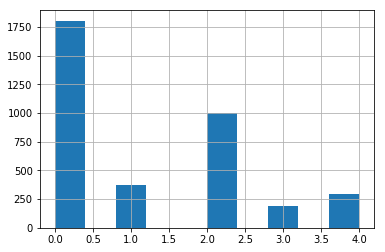

In [38]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

### Displaying some Sample Images

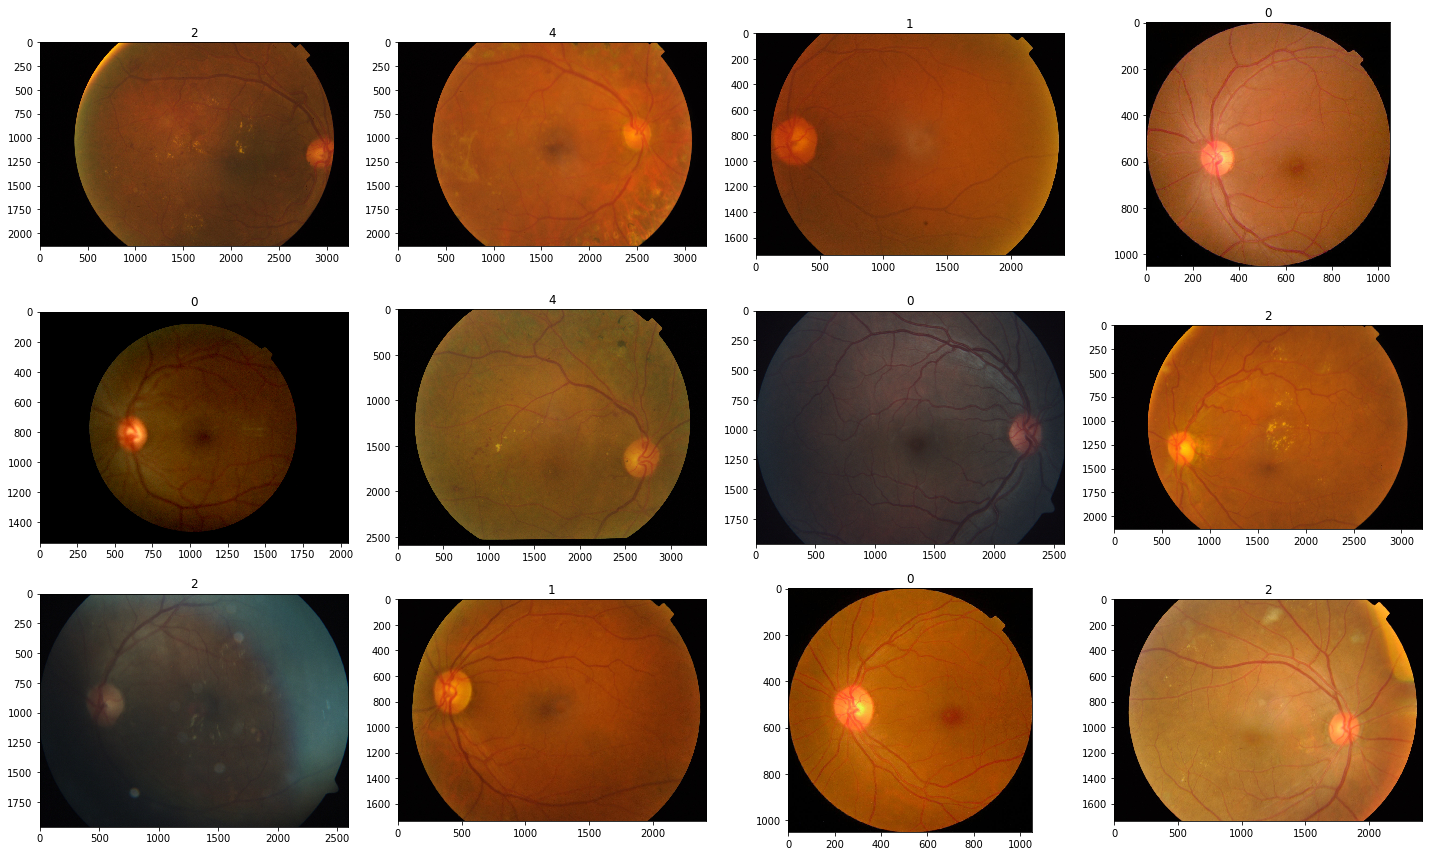

In [39]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'../input/aptos2019-blindness-detection/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

# Preprocess



In [40]:
# image height and image width ----> GLOBAL
img_ht = 380
img_wd = 380

def displayImage(display_name, image):
    cv2.namedWindow(display_name,cv2.WINDOW_AUTOSIZE)
    cv2.imshow(display_name, image)

def findContourEye(thresh_image):
    cnts = cv2.findContours(thresh_image.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
#     cnts = imutils.grab_contours(cnts)
    cnts = max(cnts[0], key=cv2.contourArea)
    return cnts

def findContourEyeExtreme(cnts):
    # Locating extreme points on all 4 sides
    leftmost = tuple(cnts[cnts[:,:,0].argmin()][0])
    rightmost = tuple(cnts[cnts[:,:,0].argmax()][0])
    topmost = tuple(cnts[cnts[:,:,1].argmin()][0])
    bottommost = tuple(cnts[cnts[:,:,1].argmax()][0])
    # Locating the top left and bottom right corner
    x1 = leftmost[0]
    y1 = topmost[1]
    x2 = rightmost[0]
    y2 = bottommost[1]
    return x1,y1,x2,y2 

def findRadiusAndCentreOfContourEye(cnts):
    M = cv2.moments(cnts)
    if( M["m00"]==0):
        cX, cY = 0, 0
    else:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    if(cX < cY):
        r = cX
    else:
        r = cY
    return cX,cY,r

def drawCentreOnContourEye(image,cnts,cX,cY):
    cv2.drawContours(image, [cnts], -1, (0, 255, 0), 2)
    cv2.circle(image, (cX, cY), 7, (255, 255, 255), -1)
    cv2.putText(image, "center", (cX - 20, cY - 20),
    cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    return image
    
def Radius_Reduction(img,cX,cY,r):
    h,w,c=img.shape
    Frame=np.zeros((h,w,c),dtype=np.uint8)
    cv2.circle(Frame,(int(cX),int(cY)),int(r), (255,255,255), -1)
    Frame1=cv2.cvtColor(Frame, cv2.COLOR_BGR2GRAY)
    img1 =cv2.bitwise_and(img,img,mask=Frame1)
    return img1

def imageResize(image, ht, wd):
    # resized_image = imutils.resize(image, height = ht, width = wd)
    resized_image = cv2.resize(image,(wd,ht))
    return resized_image

def crop_black(image):
    org = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(blurred, 10, 255, cv2.THRESH_BINARY)[1]
    # displayImage('thresh',thresh)
    cnts = findContourEye(thresh)
    x1,y1,x2,y2 = findContourEyeExtreme(cnts)
#     print(x1,y1,x2,y2)
#     crop = org[y1:y2, x1:x2]
#     crop = imageResize(crop, img_ht, img_wd)
#     # displayImage("cr1",crop)
#     return crop
    ext_x = int((x2 - x1)*4//100)
    ext_y = int((y2 - y1)*5//100)
#     print(ext_x,ext_y)
    crop = org[y1+ext_y:y2-ext_y, x1+ext_x:x2-ext_x]
    crop = imageResize(crop, img_ht, img_wd)
    return crop

def imageAugmentation(image):
    x_flip = cv2.flip( image, 0 )
    y_flip = cv2.flip( image, 1 )
    xy_flip = cv2.flip(x_flip,1)
    return x_flip, y_flip, xy_flip

def imageHistEqualization(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final

def subtract_median_bg_image(im):
    k = np.max(im.shape)//20*2+1
    bg = cv2.medianBlur(im, k)
    sub_med = cv2.addWeighted (im, 1, bg, -1, 255)
    return sub_med

def colorEnhancement(image1,image2):
    image_final = cv2.bitwise_and(image1,image2)
    return image_final

def imageAugSave(path,img1,img2,img3,img4,img_ht,img_wd):
    count = len(os.listdir(path))

    img1 = imageResize(img1, img_ht, img_wd)
    img2 = imageResize(img2, img_ht, img_wd)
    img3 = imageResize(img3, img_ht, img_wd)
    img4 = imageResize(img4, img_ht, img_wd)

    cv2.imwrite(os.path.join(path , '%d.png'%(count+1)), img1)
    cv2.imwrite(os.path.join(path , '%d.png'%(count+2)), img2)
    cv2.imwrite(os.path.join(path , '%d.png'%(count+3)), img3)
    cv2.imwrite(os.path.join(path , '%d.png'%(count+4)), img4)
    return count+1,count+2,count+3,count+4

def processed_test_save(path,img,img_ht,img_wd):
    count = len(os.listdir(path))
    img = imageResize(img,img_ht,img_wd)
    cv2.imwrite(os.path.join(path , '%d.png'%(count+1)), img)
    return count+1
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def new_preprocess_image(image_path, desired_size=380):
    image = cv2.imread(image_path)
    image = imageResize(image, desired_size, desired_size)
    image_crop = crop_black(image)
    image_clahe = imageHistEqualization(image_crop)
    sub_med = subtract_median_bg_image(image_clahe)
    image_final = colorEnhancement(sub_med, image_clahe)
    return image_final

# def preprocess_image(image_path, desired_size=380):
#     im = Image.open(image_path)
#     im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
#     return im


In [41]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def preprocess_image(image_path, desired_size=380):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

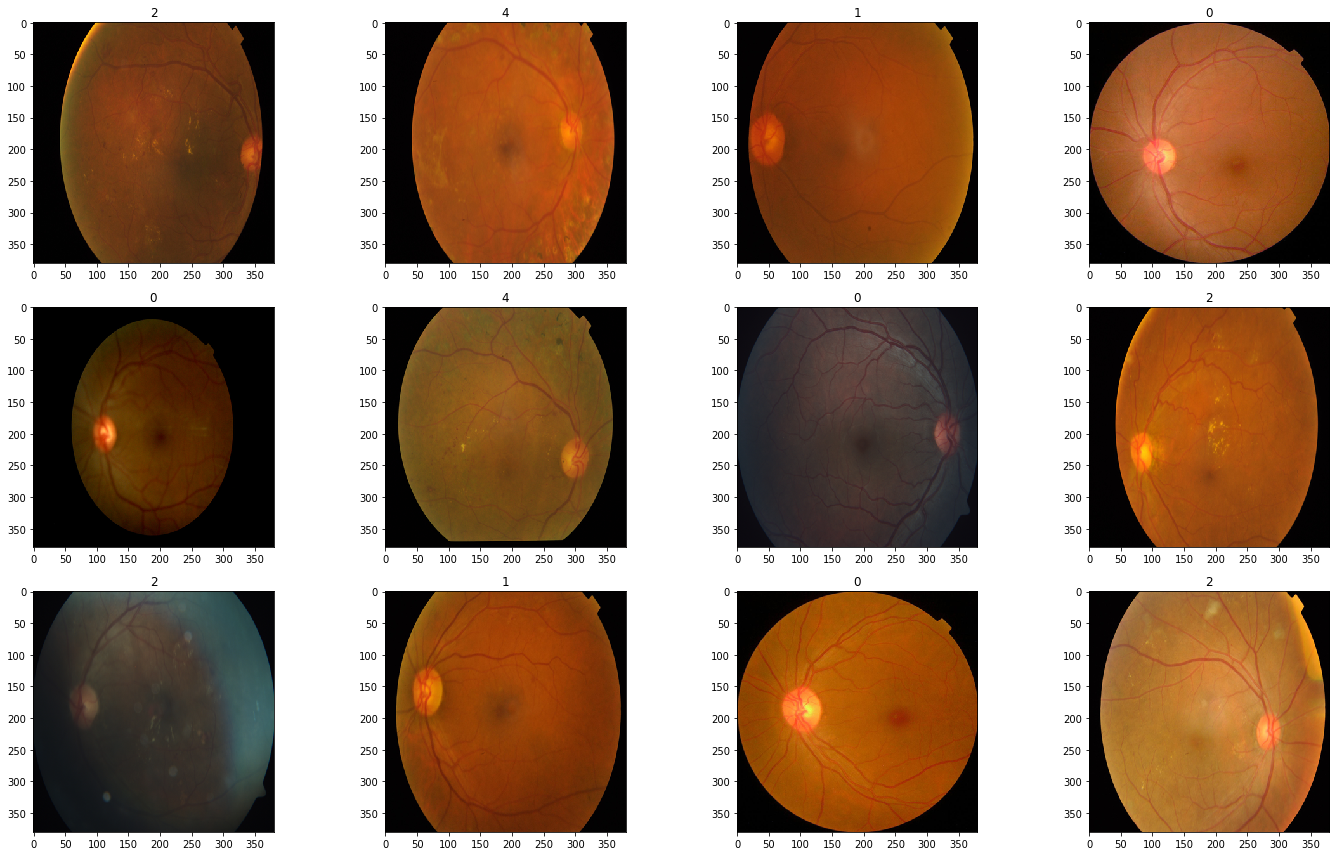

In [42]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = preprocess_image(f'../input/aptos2019-blindness-detection/train_images/{image_path}.png')
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)


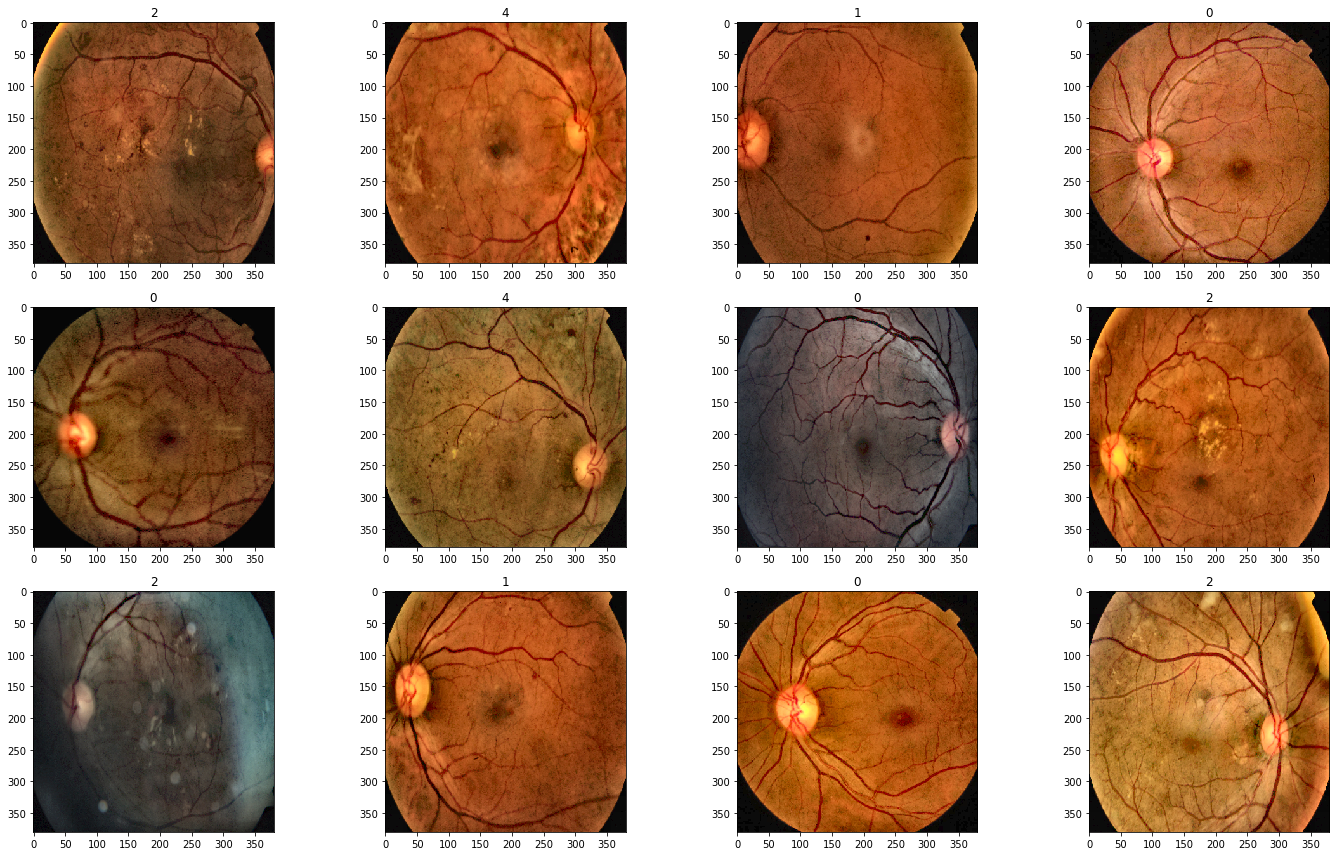

In [43]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = new_preprocess_image(f'../input/aptos2019-blindness-detection/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)


# Efficienetnet

In [44]:
import gc
gc.collect()
import os
import sys
# Repository source: https://github.com/qubvel/efficientnet
sys.path.append(os.path.abspath('../input/efficientnet/efficientnet-master/efficientnet-master/'))

In [45]:
def build_model():
    model = Sequential()
    model.add(cnn_net)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [46]:
from efficientnet import EfficientNetB3
# Load in EfficientNetB3
cnn_net = EfficientNetB3(weights=None,
                        include_top=False,
                        input_shape=(300, 300, 3))
cnn_net.load_weights('../input/efficientnet-keras-weights-b0b5/efficientnet-b3_imagenet_1000_notop.h5')

model_b3 = build_model()
model_b3.load_weights('../input/diabetic-retinopathy-models/effnet_b3.h5')
model_b3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 10, 10, 1536)      10783528  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1536)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 7685      
Total params: 10,791,213
Trainable params: 10,703,917
Non-trainable params: 87,296
_________________________________________________________________


In [47]:
from efficientnet import EfficientNetB5
# Load in EfficientNetB5
cnn_net = EfficientNetB5(weights=None,
                        include_top=False,
                        input_shape=(456, 456, 3))
cnn_net.load_weights('../input/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5')

model_b5 = build_model()
model_b5.load_weights('../input/diabetic-retinopathy-models/effnet_b5.h5')
model_b5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Model)      (None, 15, 15, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 2048)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 10245     
Total params: 28,523,765
Trainable params: 28,351,029
Non-trainable params: 172,736
_________________________________________________________________


In [48]:
from efficientnet import EfficientNetB5
# Load in EfficientNetB5
cnn_net = EfficientNetB5(weights=None,
                        include_top=False,
                        input_shape=(380, 380, 3))
cnn_net.load_weights('../input/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5')

model_prc = build_model()
model_prc.load_weights('../input/diabetic-retinopathy-models/effb5_old_new_preprocess.h5')
model_prc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Model)      (None, 12, 12, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 10245     
Total params: 28,523,765
Trainable params: 28,351,029
Non-trainable params: 172,736
_________________________________________________________________


In [49]:
from efficientnet import EfficientNetB5
# Load in EfficientNetB5
cnn_net = EfficientNetB5(weights=None,
                        include_top=False,
                        input_shape=(456, 456, 3))
cnn_net.load_weights('../input/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5')

model_old = build_model()
model_old.load_weights('../input/m1-effnetb5-using-ram-fork1-3a0430/model.h5')
model_old.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Model)      (None, 15, 15, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d_10  (None, 2048)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 10245     
Total params: 28,523,765
Trainable params: 28,351,029
Non-trainable params: 172,736
_________________________________________________________________


## Submit

In [ ]:
 min_class = str(l_ans[0])
        max_class = str(l_ans[1])
        return ("Diabetis Retinopathy class is between class : %s to class : %s",min_class,max_class)

In [59]:
from collections import Counter
import random

def mode_ans(lst):
    l_ans = []
    d_mem_count = Counter(lst)
    cnt_max = max(d_mem_count.values())
    for k in d_mem_count.keys():
        if(d_mem_count[k] == cnt_max):
            l_ans.append(k)
    if(len(l_ans) == 1):
        return "Diabetis Retinopathy class is :"+str(l_ans[0])
    else:
        l_ans.sort()
        return "Diabetis Retinopathy class is between class : "+str(l_ans[0])+" to class : "+str(l_ans[-1])
#         return random.choice(l_ans)

In [62]:
cnt_b3 = 0
cnt_b5 = 0
cnt_old = 0
cnt_mode = 0
cnt_prc = 0
from statistics import mode
from collections import Counter
# train_df = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')

S = 950
N = 955
for i in tqdm(range(S,N)):
        
    img_b3 = preprocess_image('../input/aptos2019-blindness-detection/train_images/%s.png'%train_df['id_code'][i],desired_size = 300)
    img_b3 = np.expand_dims(img_b3,axis = 0)
    ans_b3 = model_b3.predict(img_b3) > 0.5
    ans_b3 = (ans_b3.astype(int).sum(axis=1) - 1)[0]
    if(ans_b3 == train_df['diagnosis'][i]):
        cnt_b3 += 1
    
    img_b5 = preprocess_image('../input/aptos2019-blindness-detection/train_images/%s.png'%train_df['id_code'][i],desired_size = 456)
    img_b5 = np.expand_dims(img_b5,axis = 0)
    ans_b5 = model_b5.predict(img_b5) > 0.5
    ans_b5 = (ans_b5.astype(int).sum(axis=1) - 1)[0]   
    if(ans_b5 == train_df['diagnosis'][i]):
        cnt_b5 += 1
        
    img_prc = new_preprocess_image('../input/aptos2019-blindness-detection/train_images/%s.png'%train_df['id_code'][i],desired_size = 380)
    img_prc = np.expand_dims(img_prc,axis = 0)
    ans_prc = model_prc.predict(img_prc) > 0.5
    ans_prc = (ans_prc.astype(int).sum(axis=1) - 1)[0]   
    if(ans_prc == train_df['diagnosis'][i]):
        cnt_prc += 1
        
    img_old = preprocess_image('../input/aptos2019-blindness-detection/train_images/%s.png'%train_df['id_code'][i],desired_size = 456)
    img_old = np.expand_dims(img_old,axis = 0)
    ans_old = model_old.predict(img_old) > 0.5
    ans_old = (ans_old.astype(int).sum(axis=1) - 1)[0]   
    if(ans_old == train_df['diagnosis'][i]):
        cnt_old += 1
    
    print(train_df['id_code'][i]+".png","\nModel Predictions : ",ans_b3,ans_b5,ans_prc,ans_old)
#     ------------------------------------------------------------------------------------------------------------------------
    
    l = [ans_b3,ans_b5,ans_prc,ans_old]
    ans_mode = mode_ans(l)
    
    print(ans_mode,"\n Actual answer : ",train_df['diagnosis'][i],"\n")
#     print("mode ans : ",ans_mode,"final ans : ",train_df['diagnosis'][i])
   
N = N - S
print(cnt_b3,cnt_b5,cnt_prc,cnt_old)
print(cnt_b3/N,cnt_b5/N,cnt_prc/N,cnt_old/N)

import gc
gc.collect()


44271f3cb18f.png 
Model Predictions :  0 0 0 0
Diabetis Retinopathy class is :0 
 Actual answer :  0 

445a8a6da55c.png 
Model Predictions :  0 0 0 0
Diabetis Retinopathy class is :0 
 Actual answer :  0 

4462fba1d2a1.png 
Model Predictions :  4 3 4 3
Diabetis Retinopathy class is between class : 3 to class : 4 
 Actual answer :  4 

4464bb62bf20.png 
Model Predictions :  0 0 0 0
Diabetis Retinopathy class is :0 
 Actual answer :  0 

4478b870e549.png 
Model Predictions :  2 2 2 2
Diabetis Retinopathy class is :2 
 Actual answer :  2 

5 4 5 4
1.0 0.8 1.0 0.8


0